In [108]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import wrangle
import acquire
import prepare
import explore

from scipy import stats
from math import sqrt

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.feature_selection import f_regression 

In [109]:
#Using my acquire.py module, the function new_zillow_data brings in a df that contains:
#columns for single unit properties from 2017 that have had a transaction from May-Aug.
#single unit properties have been defined as: 
#residential single family homes, townhouse, bungalow, and patio homes
#determined based on likliehood of entire unit and property lot/land being owned and used for 
#single owner residential use.
#this dataframe is located in the Codeup SQL database.

df = acquire.new_zillow_data()
df.head()

,parcelid,airconditioningtypeid,heatingorsystemtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,...,poolcnt,propertylandusetypeid,regionidneighborhood,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt,numberofstories,taxamount,taxvaluedollarcnt
0,11721753,NaN,7.0,NaN,NaN,2.0,3.0,1316.0,6037.0,NaN,...,NaN,261.0,268581.0,NaN,NaN,1.0,1923.0,NaN,2627.48,205123.0
1,11289917,1.0,2.0,NaN,NaN,2.0,3.0,1458.0,6037.0,NaN,...,1.0,261.0,NaN,NaN,NaN,1.0,1970.0,NaN,2319.90,136104.0
2,11705026,NaN,2.0,NaN,NaN,1.0,2.0,1421.0,6037.0,NaN,...,NaN,261.0,118208.0,NaN,NaN,1.0,1911.0,NaN,543.69,35606.0
3,14269464,NaN,NaN,NaN,NaN,3.0,4.0,2541.0,6059.0,NaN,...,NaN,261.0,NaN,NaN,NaN,NaN,2003.0,NaN,9819.72,880456.0
4,11446756,NaN,7.0,NaN,NaN,2.0,3.0,1491.0,6037.0,NaN,...,NaN,261.0,274750.0,NaN,NaN,1.0,1955.0,NaN,1399.27,107110.0


In [110]:
df.shape

(28127, 22)

In [144]:
#Clean and split using acquire.py module function
#train, validate, test = acquire.clean_zillow_data(df)
#train.head()

df = acquire.clean_zillow_data(df)
df.head()

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county,tax_rate
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0,1,0,0,0.0128
1,11289917,2.0,3.0,1458,6037.0,261.0,1970,2319.90,136104.0,1,0,0,0.0170
2,11705026,1.0,2.0,1421,6037.0,261.0,1911,543.69,35606.0,1,0,0,0.0153
3,14269464,3.0,4.0,2541,6059.0,261.0,2003,9819.72,880456.0,0,1,0,0.0112
4,11446756,2.0,3.0,1491,6037.0,261.0,1955,1399.27,107110.0,1,0,0,0.0131


In [170]:
#Creating a dataframe that contains tax rates for the three counties in this dataset.
# LA County is 6037, Orange County is 6059, and Ventura County is 6111.
tax_df = df[['fips', 'tax_rate']]
tax_df['county'] = tax_df['fips'].map({6037: 'LA County', 6059: 'Orange County', 6111: 'Ventura County'})
tax_df.head()

,fips,tax_rate,county
0,6037.0,0.0128,LA County
1,6037.0,0.0170,LA County
2,6037.0,0.0153,LA County
3,6059.0,0.0112,Orange County
4,6037.0,0.0131,LA County


In [171]:
la_county_tax = tax_df[tax_df.county == "LA County"].tax_rate
oc_tax = tax_df[tax_df.county == "Orange County"].tax_rate
ventura_tax = tax_df[tax_df.county == "Ventura County"].tax_rate

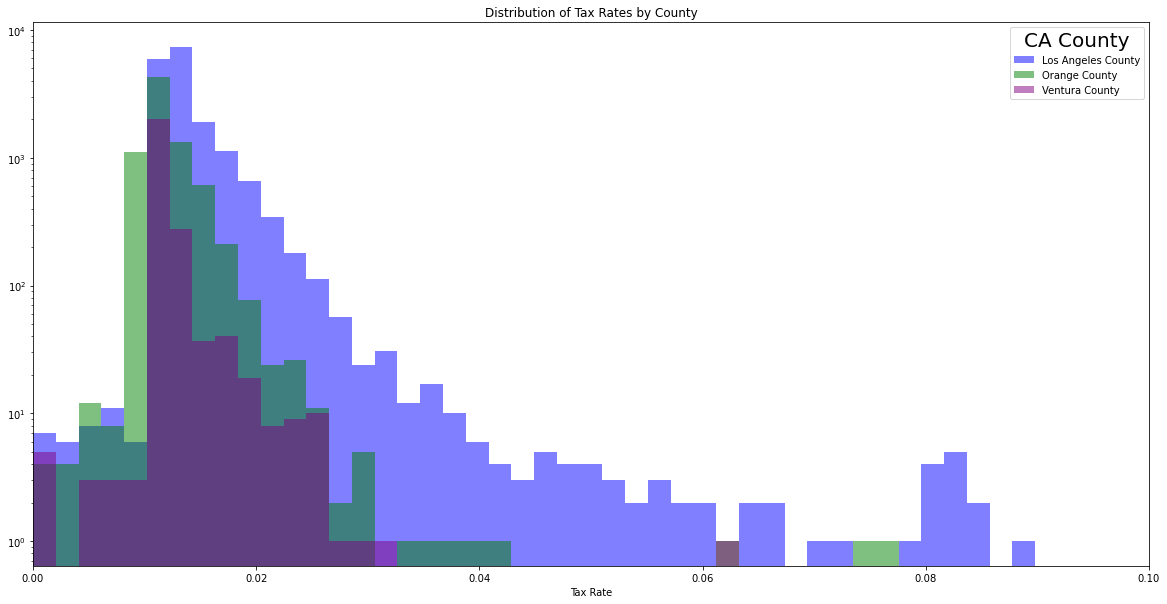

In [176]:
plt.figure(figsize=(20,10))
    # start plot
plt.hist(la_county_tax, bins=np.linspace(0, 0.1, 50), color='blue', alpha=0.50, log=True, label='Los Angeles County')
plt.hist(oc_tax, bins=np.linspace(0, 0.1, 50), color='green', alpha=0.50, log=True, label='Orange County')
plt.hist(ventura_tax, bins=np.linspace(0, 0.1, 50), color='purple', alpha=0.50, log=True, label='Ventura County')
plt.rcParams['legend.title_fontsize'] = 20
plt.xlim(0, 0.1)
plt.xlabel('Tax Rate')
plt.title('Distribution of Tax Rates by County')
plt.legend(title='CA County')
plt.show()

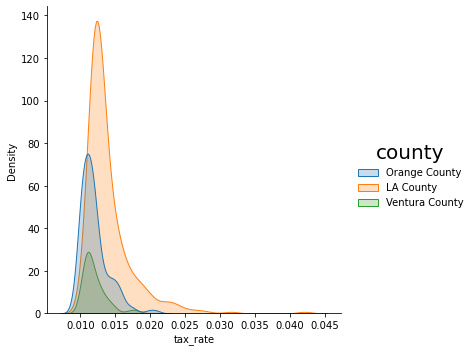

In [180]:
#sns.displot(tax_df.sample(500), x="tax_rate", hue="county", element="step")
sns.displot(tax_df.sample(500), x="tax_rate", hue="county", kind="kde", fill=True)

In [4]:
#remove outliers
k = 1.5
col_list = ['bedrooms', 'bathrooms', 'total_sqft', 'tax_value', 'taxamount', 'year_built']

df = acquire.remove_outliers(df, k, col_list)
df.head()

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county,tax_rate
0,11721753,2.0,3.0,1316,6037.0,261.0,1923,2627.48,205123.0,1,0,0,0.0128
1,11289917,2.0,3.0,1458,6037.0,261.0,1970,2319.90,136104.0,1,0,0,0.0170
2,11705026,1.0,2.0,1421,6037.0,261.0,1911,543.69,35606.0,1,0,0,0.0153
3,14269464,3.0,4.0,2541,6059.0,261.0,2003,9819.72,880456.0,0,1,0,0.0112
4,11446756,2.0,3.0,1491,6037.0,261.0,1955,1399.27,107110.0,1,0,0,0.0131


In [5]:
#split the data into train, validate and test
train, validate, test = acquire.split_df(df)
train.head()

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county,tax_rate
3343,14147332,2.5,3.0,2052,6059.0,261.0,1979,5475.00,480448.0,0,1,0,0.0114
11521,11975726,1.0,2.0,654,6037.0,261.0,1921,6513.94,538082.0,1,0,0,0.0121
103,11289836,2.0,4.0,1700,6037.0,261.0,1969,3099.72,194600.0,1,0,0,0.0159
11962,14212033,3.0,4.0,2326,6059.0,261.0,1966,7841.84,732321.0,0,1,0,0.0107
21432,12892505,2.0,2.0,1574,6037.0,261.0,1954,1237.31,83217.0,1,0,0,0.0149


In [129]:
#sanity check for shape of data split
train_shape = train.shape
validate_shape = validate.shape
test_shape = test.shape

print(f'The number of rows and columns for the train set is {train_shape}')
print(f'The number of rows and columns for the validate set is {validate_shape}')
print(f'The number of rows and columns for the test set is {test_shape}')

The number of rows and columns for the train set is (13414, 13)
The number of rows and columns for the validate set is (5750, 13)
The number of rows and columns for the test set is (4791, 13)


In [130]:
df.shape

(28127, 22)

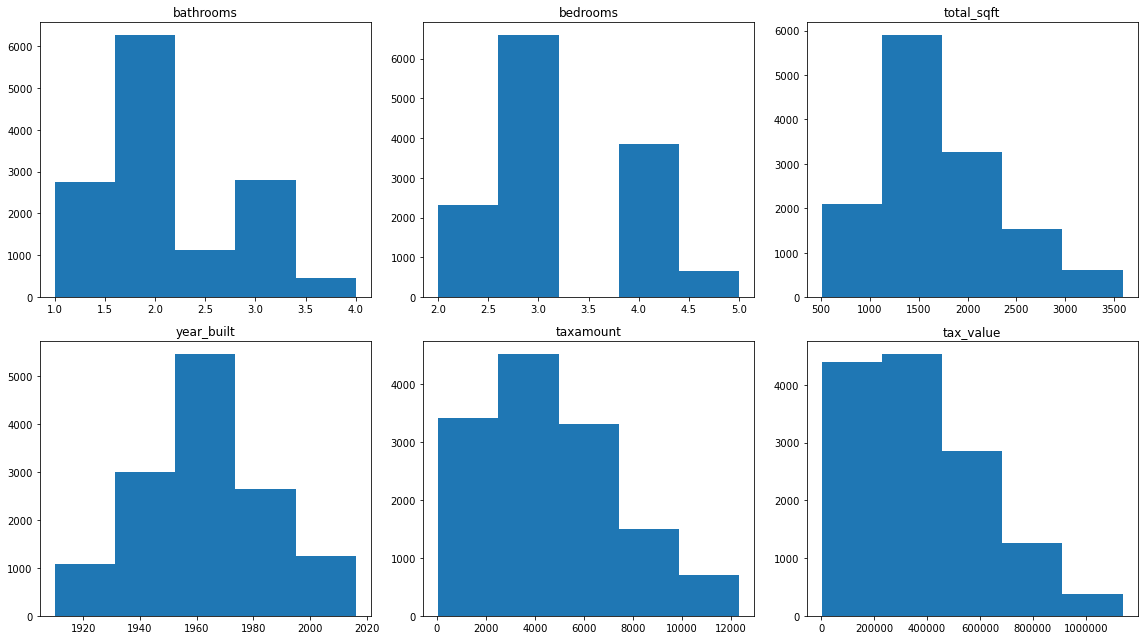

In [131]:
#now visualize train:
plt.figure(figsize=(16, 9))

# List of columns
cols = [col for col in train.columns if col not in ['propertylandusetypeid', 'parcelid','tax_rate', 'fips', 'la_county', 'orange_county', 'ventura_county']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2, (len(cols))/2, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    train[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(style='plain', useOffset=False)
    
    # mitigate overlap
    plt.tight_layout()
    
plt.show()

## The shape of data for train looks very similar to the look at features' distribution for whole dataset
## This tells me this that the train dataset is an accurate sample of the whole
**** 

In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13414 entries, 3343 to 17469
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   parcelid               13414 non-null  int64  
 1   bathrooms              13414 non-null  float64
 2   bedrooms               13414 non-null  float64
 3   total_sqft             13414 non-null  int64  
 4   fips                   13414 non-null  object 
 5   propertylandusetypeid  13414 non-null  float64
 6   year_built             13414 non-null  object 
 7   taxamount              13414 non-null  float64
 8   tax_value              13414 non-null  float64
 9   la_county              13414 non-null  uint8  
 10  orange_county          13414 non-null  uint8  
 11  ventura_county         13414 non-null  uint8  
 12  tax_rate               13414 non-null  float64
dtypes: float64(6), int64(2), object(2), uint8(3)
memory usage: 1.7+ MB


## Now I will define my target(independent) variable as y and my dependent variables as X
## X and y will be defined for train, validate and split

In [133]:
#now i will define my target(independent) variable as y
#and my dependent variables as X
#X and y will be defined for train, validate and split


X_train = train[['bathrooms', 'bedrooms', 'total_sqft', 'fips', 'year_built', 'taxamount']]

y_train = train['tax_value']

X_validate = validate[['bathrooms', 'bedrooms', 'total_sqft', 'fips', 'year_built', 'taxamount']]

y_validate = validate['tax_value']

X_test = test[['bathrooms', 'bedrooms', 'total_sqft', 'fips', 'year_built', 'taxamount']]

y_test = test['tax_value']

#sanity check test, there should be 6 independent variables, or features.
print(f'X_train -> {X_train.shape}')
print(f'X_validate -> {X_validate.shape}')
print(f'X_test -> {X_test.shape}')
print(f'y_test -> {y_test.shape}')

X_train -> (13414, 6)
X_validate -> (5750, 6)
X_test -> (4791, 6)
y_test -> (4791,)


In [12]:
#Using prepare.py from previous exercise, create and scale data

scaler, train_scaled, validate_scaled, test_scaled = prepare.gen_scaler(['bedrooms', 'bathrooms', 'total_sqft', 'taxamount'],
                                                                                 train, validate, test,
                                                                                 scaler=MinMaxScaler())

In [13]:
#sanity check
train_scaled.head()

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county,tax_rate,bedrooms_scaled,bathrooms_scaled,total_sqft_scaled,taxamount_scaled
3343,14147332,2.5,3.0,2052,6059.0,261.0,1979,5475.00,480448.0,0,1,0,0.0114,0.333333,0.500000,0.501946,0.441995
11521,11975726,1.0,2.0,654,6037.0,261.0,1921,6513.94,538082.0,1,0,0,0.0121,0.000000,0.000000,0.048638,0.526662
103,11289836,2.0,4.0,1700,6037.0,261.0,1969,3099.72,194600.0,1,0,0,0.0159,0.666667,0.333333,0.387808,0.248427
11962,14212033,3.0,4.0,2326,6059.0,261.0,1966,7841.84,732321.0,0,1,0,0.0107,0.666667,0.666667,0.590791,0.634876
21432,12892505,2.0,2.0,1574,6037.0,261.0,1954,1237.31,83217.0,1,0,0,0.0149,0.000000,0.333333,0.346952,0.096654


In [14]:
#sanity check
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13414 entries, 3343 to 17469
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   parcelid               13414 non-null  int64  
 1   bathrooms              13414 non-null  float64
 2   bedrooms               13414 non-null  float64
 3   total_sqft             13414 non-null  int64  
 4   fips                   13414 non-null  object 
 5   propertylandusetypeid  13414 non-null  float64
 6   year_built             13414 non-null  object 
 7   taxamount              13414 non-null  float64
 8   tax_value              13414 non-null  float64
 9   la_county              13414 non-null  uint8  
 10  orange_county          13414 non-null  uint8  
 11  ventura_county         13414 non-null  uint8  
 12  tax_rate               13414 non-null  float64
 13  bedrooms_scaled        13414 non-null  float64
 14  bathrooms_scaled       13414 non-null  float64
 15 

In [15]:
#I already have X_train, X_validate, X_test that include numeric and non numeric features

#Now, I'll create X_train_scaled, X_validate_scaled, and X_test_scaled that include numeric features only



In [16]:
X_train_scaled = train_scaled[['bathrooms_scaled', 'bedrooms_scaled', 'total_sqft_scaled', 'taxamount_scaled']]

X_validate_scaled = validate_scaled[['bathrooms_scaled', 'bedrooms_scaled', 'total_sqft_scaled', 'taxamount_scaled']]

X_test_scaled = test_scaled[['bathrooms_scaled', 'bedrooms_scaled', 'total_sqft_scaled', 'taxamount_scaled']]

#sanity check test, there should be 6 independent variables, or features.
print(f'X_train_scaled -> {X_train_scaled.shape}')
print(f'X_validate_scaled -> {X_validate_scaled.shape}')
print(f'X_test_scaled -> {X_test_scaled.shape}')

X_train_scaled -> (13414, 4)
X_validate_scaled -> (5750, 4)
X_test_scaled -> (4791, 4)


Text(0.5, 1.0, 'Scaled')

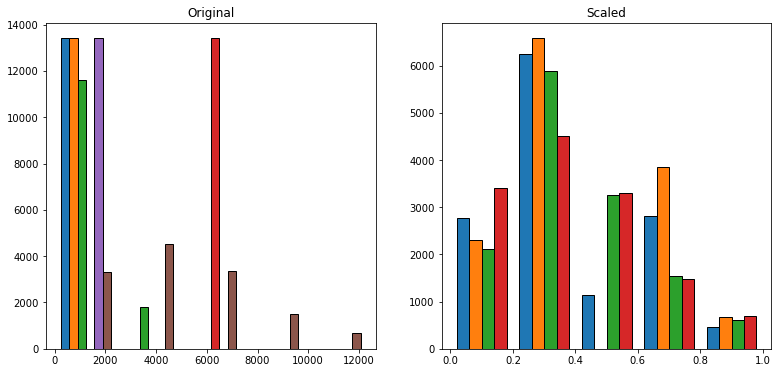

In [17]:
#quick sanity check for scaled data- looking at overall summary of train only

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=5, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=5, ec='black')
plt.title('Scaled')

array([[<AxesSubplot:title={'center':'parcelid'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'total_sqft'}>,
        <AxesSubplot:title={'center':'propertylandusetypeid'}>,
        <AxesSubplot:title={'center':'taxamount'}>],
       [<AxesSubplot:title={'center':'tax_value'}>,
        <AxesSubplot:title={'center':'la_county'}>,
        <AxesSubplot:title={'center':'orange_county'}>],
       [<AxesSubplot:title={'center':'ventura_county'}>,
        <AxesSubplot:title={'center':'tax_rate'}>, <AxesSubplot:>]],
      dtype=object)

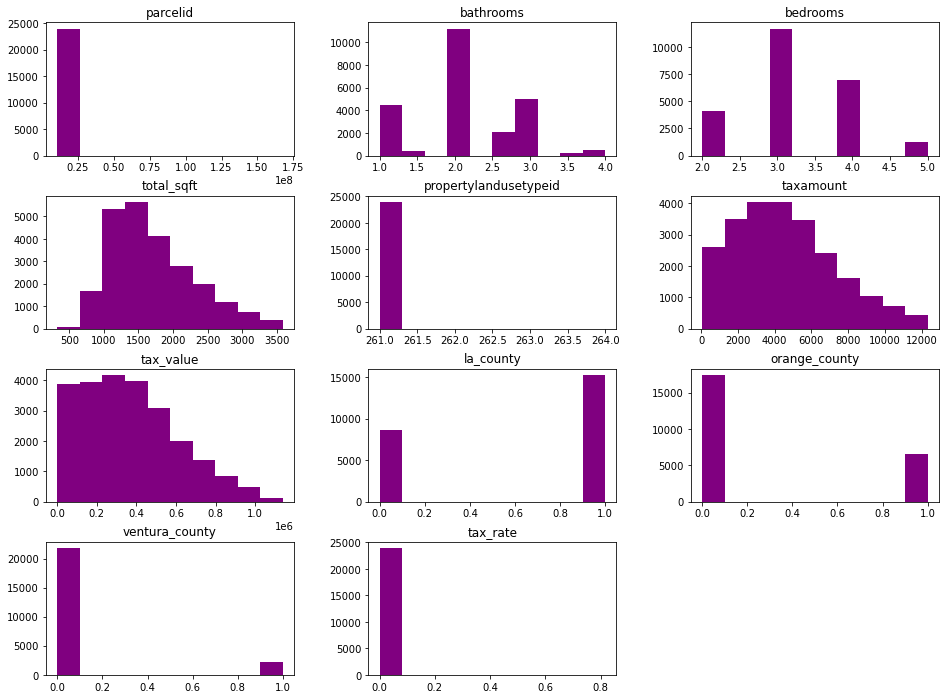

In [18]:
#Quick look back at histograms of original data
df.hist(grid=False, figsize=(16,12), color='purple')

<AxesSubplot:xlabel='bedrooms', ylabel='Density'>

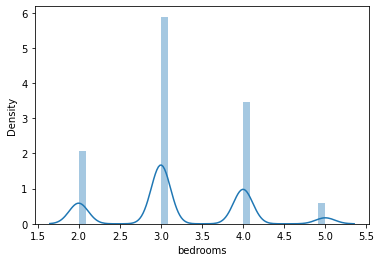

In [19]:
# default

sns.distplot(X_train.bedrooms, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)

<AxesSubplot:xlabel='bathrooms', ylabel='Density'>

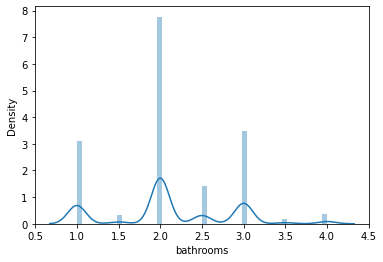

In [20]:
# default

sns.distplot(X_train.bathrooms, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)

<AxesSubplot:xlabel='total_sqft', ylabel='Density'>

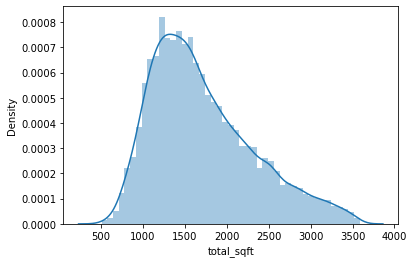

In [21]:
# default

sns.distplot(X_train.total_sqft, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)

<AxesSubplot:xlabel='year_built', ylabel='Density'>

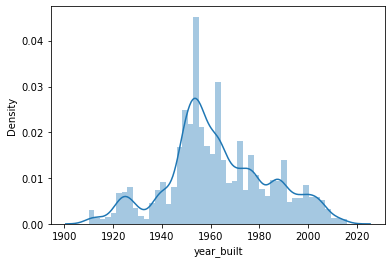

In [22]:
# default

sns.distplot(X_train.year_built, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)

In [23]:
#takeaways:  
# Most homes have 3-4 bedrooms
# Most homes have 2 bathrooms
# Most homes are between 1000 and 1500 sqft, but look normally distributed
# Most homes are built roughly between 1950-1960

## Now that we have successfully split and scaled our data, it's time to explore and look for relationships

<AxesSubplot:>

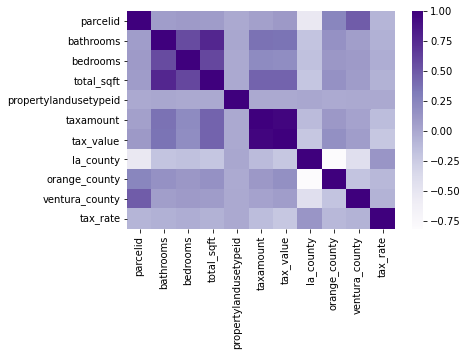

In [24]:
#basic visual with a heatmap
sns.heatmap(train.corr(), cmap='Purples', annot=False)

In [25]:
#Takeaway:  
# features that stand out to me from this heatmap are:
# orange_county, total_sqft, bathrooms and bedrooms

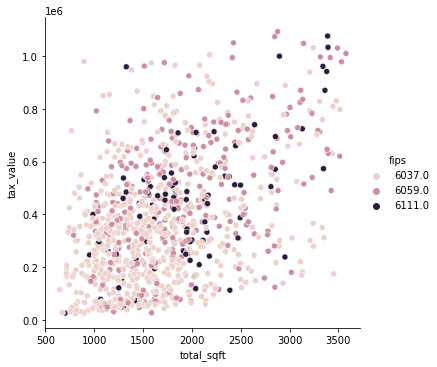

In [26]:
sns.relplot(x="total_sqft", y="tax_value", hue="fips", data=train.sample(1000));

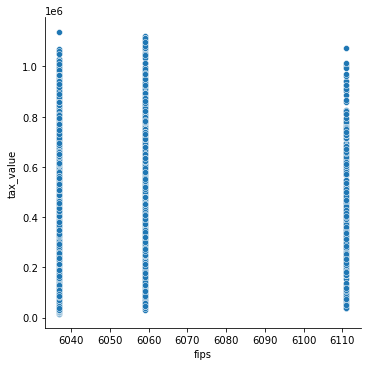

In [107]:
sns.relplot(x="fips", y="tax_value", data=train.sample(5000));

## this shows almost an even relationship between all fips codes.  
## there is likely no relationship between the fips code and our target.
## with more time, I may go back and add in zip code since a fips code could include more than one zip code.
## I can also safely assume our columns containing fips codes can be deleted.

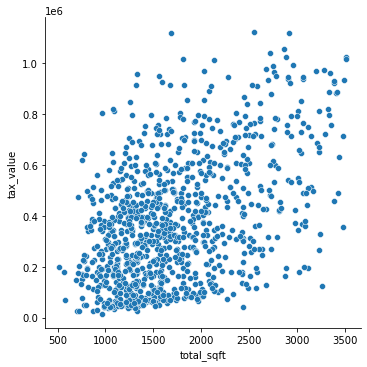

In [28]:
sns.relplot(x="total_sqft", y="tax_value", data=train.sample(1000));

In [35]:
cols = ['bathrooms', 'bedrooms', 'total_sqft', 'year_built', 'tax_value']
descriptive = {'bathrooms': 'Number of Bathrooms',
               'total_sqft': 'Total Square Feet',
               'year_built': 'Year Built',
               'tax_value': 'Tax Value',
               'bedrooms': 'Number of Bedrooms',
              '':''}

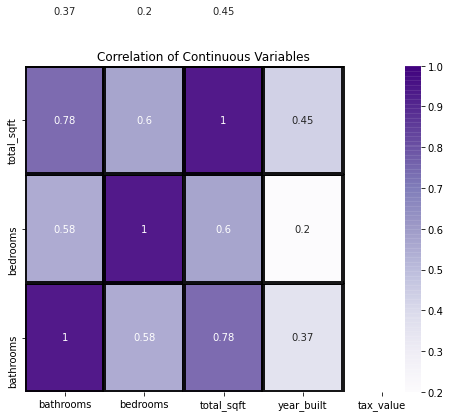

In [33]:
explore.create_heatmap(train, cols, descriptive=None)

In [36]:
#Takeaway from the above visualizations:  
#Firstly, total_sqft and bathrooms seem to have the strongest correlation,
#Next, total_sqft and bedrooms seem to have a correlation.
#This suggests that total_sqft has a stronger correlation than bathrooms and bedrooms.
#Since most properties have 2 bathrooms or less, I'd like to explore that group and properties that have more than 2 bathrooms.

### Explore correlation of the following variables: 
        - 'bathrooms', 'bedrooms', 'total_sqft', 'year_built', 'tax_value'


In [73]:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.37


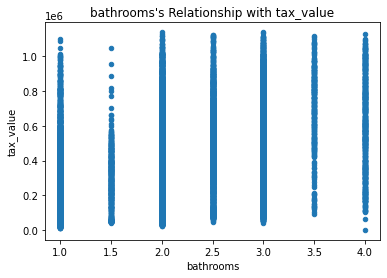

In [61]:
correlation_exploration(train, 'bathrooms', 'tax_value')

The p-value is: 1.101519648837821e-120. There is 0.0% chance that we see these results by chance.
r = 0.2


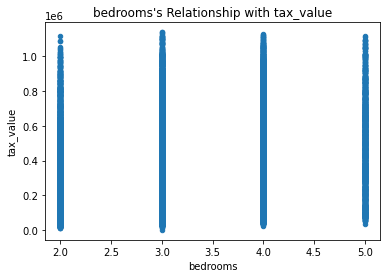

In [62]:
correlation_exploration(train, 'bedrooms', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.45


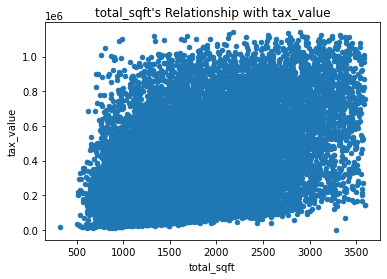

In [68]:
correlation_exploration(train, 'total_sqft', 'tax_value')

The p-value is: 5.565248014008978e-170. There is 0.0% chance that we see these results by chance.
r = 0.24


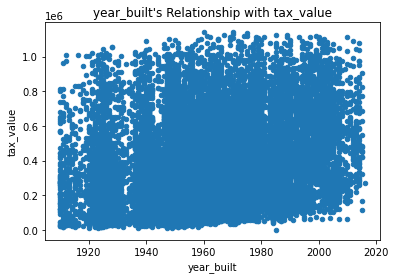

In [71]:
correlation_exploration(train, 'year_built', 'tax_value')

In [37]:
# Takeaways from Correlation tests: 
# The features bathrooms, bedrooms, and total_sqft are dependent upon tax_value.
# Now I'd like to look to see if there is a relationship to properties with greater than 2 bathrooms vs those with fewer.

In [41]:
null_hypothesis = "Single unit properties with more than 2 bathrooms and single unit properties with 2 or fewer bathrooms are independent to the tax value of the property."
alternative_hypothesis = "Single unit properties with more than 2 bathrooms and single unit properties with 2 or fewer bathrooms are dependent, or related, to the tax value of the property."

#set alpha as a with a 95% confidence rate
a = 0.05 

more_than_two_baths = train[train.bathrooms > 2]
two_or_fewer_baths = train[train.bathrooms <= 2]
t, p = stats.ttest_ind(more_than_two_baths.tax_value, two_or_fewer_baths.tax_value)


if p < a:
    print(f'The p-value is {p}, so we reject the null hypothesis that states: {null_hypothesis}')
    print (f'We are confident there is evidence to suggest that {alternative_hypothesis}')
else:
    print(f'The p-value is greater than .05, so we fail to reject null hypothesis that states, {null_hypothesis} There is not sufficient evidence to reject it.')

The p-value is 0.0, so we reject the null hypothesis that states: Single unit properties with more than 2 bathrooms and single unit properties with 2 or fewer bathrooms are independent to the tax value of the property.
We are confident there is evidence to suggest that Single unit properties with more than 2 bathrooms and single unit properties with 2 or fewer bathrooms are dependent, or related, to the tax value of the property.


## Takeaway from Explore: 
### I'm most interested in total_sqft, bathrooms and bedrooms.
### These are the features I will use in my models.
****

## Create a Baseline model, and an OLS model, then evaluate.

In [48]:
#I'm going to create a df that will hold my baseline and model predictions, and evaluations.

# Make a copy of my y_train df and name it ols_eval. I will add columns to this dataframe below.

ols_eval = pd.DataFrame(y_train.copy())

# Rename the column actual instead of home_value

ols_eval.rename(columns = {'tax_value': 'actual'}, inplace=True)

In [49]:
# Add a column to my ols_eval dataframe called 'baseline_yhat'; each value is the mean of the actual column.

ols_eval['baseline_yhat'] = ols_eval['actual'].mean()

In [50]:
#Import ols from statsmodels

from statsmodels.formula.api import ols

In [51]:
#sanity check
ols_eval.head()

,actual,baseline_yhat
3343,480448.0,374788.783062
11521,538082.0,374788.783062
103,194600.0,374788.783062
11962,732321.0,374788.783062
21432,83217.0,374788.783062


In [91]:
train_scaled.head()

,parcelid,bathrooms,bedrooms,total_sqft,fips,propertylandusetypeid,year_built,taxamount,tax_value,la_county,orange_county,ventura_county,tax_rate,bedrooms_scaled,bathrooms_scaled,total_sqft_scaled,taxamount_scaled
3343,14147332,2.5,3.0,2052,6059.0,261.0,1979,5475.00,480448.0,0,1,0,0.0114,0.333333,0.500000,0.501946,0.441995
11521,11975726,1.0,2.0,654,6037.0,261.0,1921,6513.94,538082.0,1,0,0,0.0121,0.000000,0.000000,0.048638,0.526662
103,11289836,2.0,4.0,1700,6037.0,261.0,1969,3099.72,194600.0,1,0,0,0.0159,0.666667,0.333333,0.387808,0.248427
11962,14212033,3.0,4.0,2326,6059.0,261.0,1966,7841.84,732321.0,0,1,0,0.0107,0.666667,0.666667,0.590791,0.634876
21432,12892505,2.0,2.0,1574,6037.0,261.0,1954,1237.31,83217.0,1,0,0,0.0149,0.000000,0.333333,0.346952,0.096654


In [92]:
#Create and fit the model  

ols_model = ols(formula='tax_value ~ bedrooms_scaled + bathrooms_scaled + total_sqft_scaled', data=train_scaled).fit()


In [93]:
# Create a variable to hold predictions
# I'll add these predictions to my ols_eval dataframe below.

ols_yhat = ols_model.predict(train_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']])

In [94]:
# Look at the R-squared and Prob (F-statistic) values in the summary chart.

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              tax_value   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1195.
Date:                Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                        01:49:00   Log-Likelihood:            -1.8364e+05
No. Observations:               13414   AIC:                         3.673e+05
Df Residuals:                   13410   BIC:                         3.673e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.725e+05   4175.906     41.313      0.000    1.64e+05    1.81e+05
bedrooms_scaled    -1.11e+05   9028.517    -12.299      0.000   -1.29e+05   -9.33e+04
bathrooms_scaled   8.585e+04   1.24e+04      6.909      0.000    6.15e+04     1.1e+05
total_sqft_scaled  5.493e+05   1.54e+04     35.555      0.000    5.19e+05     5.8e+05
==============================================================================
Omnibus:                      396.894   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.381
Skew:                           0.427   Prob(JB):                     4.26e-93
Kurtosis:                       2.820   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
#Now it's time to evaluate the model against the baseline predictions.

# Add a column to my ols_eval dataframe called 'ols_yhat'; This is the variable for prediction values above.

ols_eval['ols_yhat'] = ols_yhat

In [96]:
# Calculate and add a column for residuals

ols_eval['residuals'] = ols_eval.ols_yhat - ols_eval.actual

In [113]:
# Using the ols_eval DataFrame created above to hold our baseline predictions, model predictions and residuals, 
# we will now find out if our ols model's predictions can beat our baseline.

baseline_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.baseline_yhat))

ols_RMSE = sqrt(mean_squared_error(ols_eval.actual, ols_eval.ols_yhat))

print(f'The Baseline RMSE is ${round(baseline_RMSE,4)}')
print(f'The OLS RMSE is ${round(ols_RMSE,4)}')
print(f'My model has value: {ols_RMSE < baseline_RMSE}')

The Baseline RMSE is $240239.7153
The OLS RMSE is $213404.7125
My model has value: True


In [112]:
# Compute the R-squared and p-value for the Model we created and find out if our model has value.

ols_r2 = round(ols_model.rsquared,3)

ols_p_value = ols_model.f_pvalue

print(f'The R-squared score is: {ols_r2}')
print(f'My R-squared score is significant: {ols_p_value < .05}')

The R-squared score is: 0.211
My R-squared score is significant: True


(array([2.000e+00, 4.000e+00, 1.100e+01, 3.400e+01, 8.500e+01, 2.260e+02,
        5.170e+02, 1.456e+03, 3.631e+03, 1.078e+03]),
 array([ 3.93719965,  4.89155225,  5.84590485,  6.80025745,  7.75461005,
         8.70896265,  9.66331524, 10.61766784, 11.57202044, 12.52637304,
        13.48072564]),
 <BarContainer object of 10 artists>)

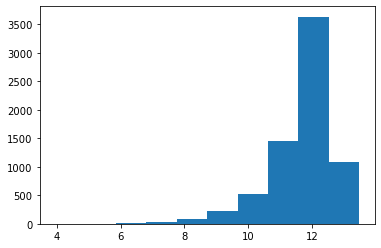

In [99]:
#Visualize residuals: 

plt.hist(np.log(ols_eval.residuals))

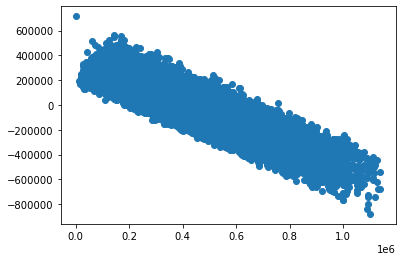

In [100]:
#Look for a possible pattern 

plt.scatter(ols_eval.actual, ols_eval.residuals)

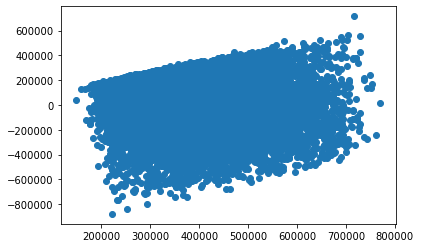

In [101]:
#Visualize predictions vs residuals:

plt.scatter(ols_eval.ols_yhat, ols_eval.residuals)

### Takeaway: OLS model using total_sqft, bedrooms and bathrooms performed better than baseline.
****

In [102]:
#Try another model using sklearn this time.
#Create the Linear Regression Object

lm = LinearRegression()

In [66]:
# Fit the Linear Regression Object to X_train_scaled and y_train

lm.fit(X_train_scaled, y_train)

LinearRegression()

In [67]:
# Use the Linear Regression Object to Return Intercept and Coefficient Values

print('intercept: ', lm.intercept_)

print("coefficients: ", lm.coef_)

intercept:  -19764.823614525492
coefficients:  [  -6856.74824528  -17349.86288159   41837.73307407 1038011.09827013]


In [68]:
# Create the `lm_eval` dataframe using a copy of the y_train dataframe.

lm_eval = pd.DataFrame(y_train.copy())

# Rename the target value `actual`

lm_eval.rename(columns={'tax_value': 'actual'}, inplace=True)

# Predict on X_train and add `yhat_lm1` column to `lm_eval` dataframe.

lm_eval['yhat_lm1'] = lm.predict(X_train_scaled)

# Calculate the residuals for my lm (linear regression model) and add `residuals_lm1` column on `lm_eval` dataframe.

lm_eval['residuals_lm1'] = lm_eval.yhat_lm1 - lm_eval.actual

### Now, it's time to Evaluate the model.

In [69]:
#sanity check
lm_eval.head()

,actual,yhat_lm1,residuals_lm1
3343,480448.0,450820.008511,-29627.991489
11521,538082.0,528950.646592,-9131.353408
103,194600.0,240478.419405,45878.419405
11962,732321.0,647822.926769,-84498.073231
21432,83217.0,92793.700168,9576.700168


In [70]:
# Calculate and display the RMSE for lm (linear regression model)

RMSE_lm1 = np.sqrt(mean_squared_error(lm_eval.actual, lm_eval.yhat_lm1))

print('The Root Mean Squared Error is {:.3}'.format(RMSE_lm1))

# Calculate and display the r-squared for my lm

r2_lm1 = r2_score(lm_eval.actual, lm_eval.yhat_lm1)

print('Using my Train dataset in my Linear Regression Model')

print()

print(f'{r2_lm1:.2%} of the variance in my target value can be explained by the features in my Linear Regression Model.')

The Root Mean Squared Error is 6.12e+04
Using my Train dataset in my Linear Regression Model

93.51% of the variance in my target value can be explained by the features in my Linear Regression Model.


In [83]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

y_train.head()

,tax_value,pred_lm
3343,480448.0,454138.305420
11521,538082.0,199233.477808
103,194600.0,340121.417359
11962,732321.0,480233.575817
21432,83217.0,391709.160834


In [104]:
#Create Baseline predictions

# 1. Predict pred_mean (which is a baseline prediction)
pred_mean = y_train['tax_value'].mean()
y_train['pred_mean'] = pred_mean
y_validate['pred_mean'] = pred_mean

# 2. compute pred_median
pred_median = y_train['tax_value'].median()
y_train['pred_median'] = pred_median
y_validate['pred_median'] = pred_median

# 3. RMSE of pred_mean
rmse_train = sqrt(mean_squared_error(y_train.tax_value, y_train.pred_mean))
rmse_validate = sqrt(mean_squared_error(y_validate.tax_value, y_validate.pred_mean))

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of pred_median
rmse_train = sqrt(mean_squared_error(y_train.tax_value, y_train.pred_median))
rmse_validate = sqrt(mean_squared_error(y_validate.tax_value, y_validate.pred_median))

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  240239.72 
Validate/Out-of-Sample:  237636.71
RMSE using Median
Train/In-Sample:  242297.83 
Validate/Out-of-Sample:  238881.6


In [114]:
# create a Linear Regression model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. 
lm.fit(X_train_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']], y_train.tax_value)

# predict train
y_train['pred_lm'] = lm.predict(X_train_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(1/2)

# predict validate
y_validate['pred_lm'] = lm.predict(X_validate_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: $", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: $", round(rmse_validate, 2))

RMSE for OLS using LinearRegression
Training/In-Sample: $ 213404.71 
Validation/Out-of-Sample: $ 212918.56


In [115]:
# create the a Lasso Lars model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']], y_train.tax_value)

# predict train
y_train['pred_lars'] = lars.predict(X_train_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(1/2)

# predict validate
y_validate['pred_lars'] = lars.predict(X_validate_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: $", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: $", round(rmse_validate, 2))

RMSE for Lasso + Lars
Training/In-Sample: $ 213404.89 
Validation/Out-of-Sample: $ 212913.06


### The two models are almost identical.
### With more time, I'd go back and fine tune more, do even more feature engineering, and try other models.


In [134]:
y_test = pd.DataFrame(y_test)
y_test.shape
#X_test_scaled.shape

(4791, 1)

In [135]:
# predict test
y_test['pred_lars'] = lars.predict(X_test_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTesting Unseen Sample: $", round(rmse_test, 2))
     

RMSE for Lasso + Lars
Testing Unseen Sample: $ 210479.86


In [136]:
# predict test
y_test['pred_lm'] = lm.predict(X_test_scaled[['bedrooms_scaled', 'bathrooms_scaled', 'total_sqft_scaled']])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nUnseen Test Sample: $", round(rmse_test, 2))
    

RMSE for OLS using LinearRegression
Unseen Test Sample: $ 210485.18


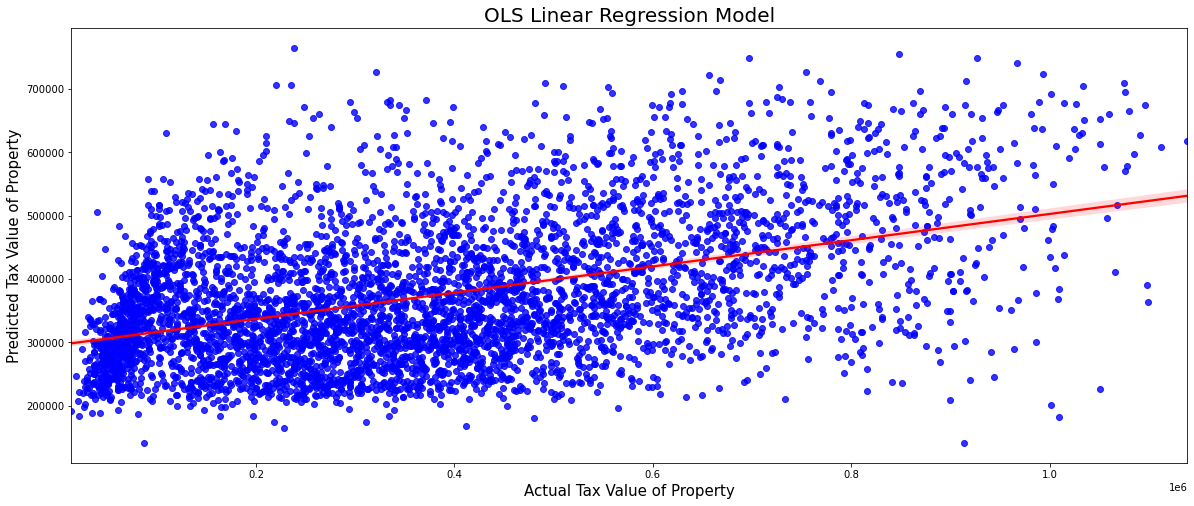

In [139]:
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_test.tax_value, y=y_test.pred_lm, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property", fontdict={'fontsize':15})
plt.title("OLS Linear Regression Model", fontdict={'fontsize': 20})

plt.show()